In [2]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from equationmodel_gp import gp_regression, prediction_rmse_error, gp_train_graph, gp_linear_compare_graph
from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

ADD data preprocessing
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
          type  distance  pathloss  heightTM  frequency  heightTB  heightB  heightM
type 6355    m      2.97    124.62      0.02       1399        30       15        2
     6356    m      2.96    123.33      0.02       1399        30       15        2
     6357    m      2.96    121.37      0.02       1399        30       15        2
     6358    m      2.95    121.60      0.02       1399        30       15        2
     6359    m      2.91    114.82      0.02       1399        30       15        2
Combined data set: (31188, 8)
type filterin

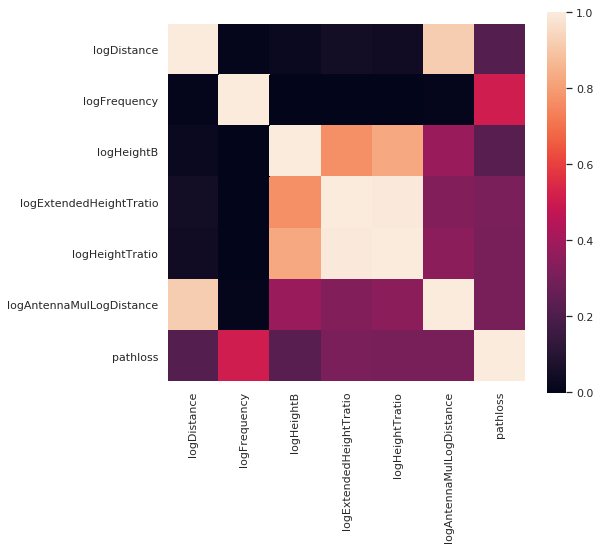

In [5]:
%autoreload

iksan_fileList = {'../data/PLdata_iksan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

targetCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance']
yCols = 'pathloss'

print("\nADD data description")
print(addData.describe()['pathloss'])
# print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data[pathloss]")
print(addData.cov()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)


In [20]:
%autoreload
samplingRatio = 0.1
addDataSample = samplingData(addData[targetCols], samplingRatio)
# addDataSample.sort_values(by=['logDistance'])

normalizer = 'standard'

X, scaler = normalizeData(addDataSample[xCols], scaler = normalizer)
Y = np.array(addDataSample[yCols])

data distribution(before)
       logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance  pathloss
count     79125.00      79125.00    79125.00    79125.00                 79125.00         79125.00                  79125.00  79125.00
mean          0.31          3.03        1.05        0.30                    -0.40            -0.32                      0.32    127.47
std           0.12          0.32        0.16        0.00                     0.26             0.33                      0.14     16.61
min           0.00          2.60        0.85        0.30                    -0.95            -1.00                      0.00     85.06
25%           0.23          2.60        0.85        0.30                    -0.62            -0.62                      0.24    114.91
50%           0.33          3.15        1.18        0.30                    -0.39            -0.27                      0.33    127.17
75%           0.40          3

In [22]:
kf = KFold(n_splits=5, shuffle=True)

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    print("X_train shape:{}, y_train shape:{}, X_test shape:{}, y_test shape:{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    model = gp_regression(X_train, y_train.flatten())

#     trainError = prediction_rmse_error(model.predict(X_train), y_train)
#     testError = prediction_rmse_error(model.predict(X_test), y_test)
    
    pred_train, std_train = model.predict(X_train, return_std=True)
    pred_test, std_test = model.predict(X_test, return_std=True)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    print("GP-Model-"+str(i)+"-train error(RMSE):", trainError)
    print("GP-Model-"+str(i)+"-test error(RMSE):", testError) 
    
    print("GP-Model-"+str(i)+"-STD DEVIATION:", std_train)
    print("GP-Model-"+str(i)+"-STD DEVIATION:", std_test)    
    stdTrainSum = np.add(std_train,stdTrainSum)
    stdTestSum = np.add(std_test, stdTestSum)
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    modelList.append(model)
    filename = 'model/gp_model_' + str(i) + '.sav'
    pickle.dump(modelList[-1], open(filename, 'wb'))
    i+=1
i-=1
avgStdTrain = np.divide(stdTrainSum, i)
print(avgStdTrain)

X_train shape:(6329, 7), y_train shape:(6329,), X_test shape:(1583, 7), y_test shape:(1583,)
GP-Model-1-train error(RMSE): 0.5956801557360734
GP-Model-1-test error(RMSE): 10.105262181540452
GP-Model-1-STD DEVIATION: [2.81780788 2.84073975 2.83978861 ... 2.83007492 2.83603969 2.83849982]
GP-Model-1-STD DEVIATION: [ 2.90433678  8.62385487  7.96885642 ... 11.87489067  8.93947026
  8.88445636]
X_train shape:(6329, 7), y_train shape:(6329,), X_test shape:(1583, 7), y_test shape:(1583,)
GP-Model-2-train error(RMSE): 1.2006024325652704
GP-Model-2-test error(RMSE): 10.072757745861985
GP-Model-2-STD DEVIATION: [4.3231962  4.37624147 4.34604767 ... 4.33894124 4.37148544 4.37989427]
GP-Model-2-STD DEVIATION: [12.08269452  9.75246915 10.64409677 ... 11.11690093 11.69153943
  9.81873897]
X_train shape:(6330, 7), y_train shape:(6330,), X_test shape:(1582, 7), y_test shape:(1582,)
GP-Model-3-train error(RMSE): 0.688636701638844
GP-Model-3-test error(RMSE): 10.236316495003722
GP-Model-3-STD DEVIATION:

ValueError: operands could not be broadcast together with shapes (6330,) (6329,) 